Compute cross-correlation for galaxies within the protocluster regions coeval with CLAMATO, and compare with those outside. 

The protoclusters in question are identified as galaxy overdensities from Cucciati+2018 and Nanayakkara+2016:
* http://adsabs.harvard.edu/abs/2018arXiv180606073C
* http://adsabs.harvard.edu/abs/2016ApJ...828...21N

For now, we are working off the COSMOS stellar masses calculated for the coeval galaxy sample by YK Chiang, which is supposed to be matched to my xcorr galaxy catalog but need to double check later.

In [1]:
# This is a cell to hide code snippets from displaying
# This must be at first cell!

from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:

import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from numpy.lib import recfunctions as recfuncs

# Random seed
np.random.seed(seed=79830285)

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# These are coordinates of the tomographic map, for use as zero-point of the Mpc grid
ra0 = 149.950000
dec0 = 2.150000
ra1 = 150.39359
dec1 =  2.5048765

zmin = 2.0
zmax = 2.6
zmid = (zmin+zmax)/2.

# degrees per transverse cMpc
deg_per_Mpc = 1. / cosmo.comoving_distance(zmid).value * 180./np.pi
print('Comoving distance to z={:f} (in Mpc): {:f}'.format(
    zmid,cosmo.comoving_distance(zmid)))
dcomdisdz = 2998. * cosmo.inv_efunc(zmid)

# Read LyaF pixels and binning for the cross-correlation
lyapix = xcorr.lyapix("pixel_radecz_cl2017_v4.bin",cosmo=cosmo)
print("Read in %i Ly-a forest pixels" % lyapix.npix)
npix = lyapix.npix


PiBin_fil  = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

PiBound = (min(PiEdges), max(PiEdges) )
#print('Pi bin edges in Mpc:')
#print(PiEdges)
#print('Sigma bin edges in Mpc:')
#print(SigEdges)

Comoving distance to z=2.300000 (in Mpc): 5535.390251 Mpc
Read in 92772 Ly-a forest pixels


Read in galaxy catalog with stellar masses. This is ~consistent with the Clotilde+2015 catalog, only that we fix the redshift to the spectro-z rather than using a photo-z.

For the galaxies, we make sure the galaxy catalog is unique (i.e. galaxies with redshifts from more than one spectroscopic survey is represented only once), remove NaN stellar masses, and also get rid of 3D-HST since those grism redshifts are too uncertain for the protoclusters. 

In [3]:

gal_cat_fil = 'CLAMATO_2017_Cross-correlation_catalog_w_Mstar.txt'
galcat = ascii.read(gal_cat_fil)

# Filter for unique [RA, Dec]
gx = galcat['ra']
gy = galcat['dec']
xy_gal = np.transpose([gx, gy])
xy_galarr = tuple(xy_galtmp for xy_galtmp in xy_gal)
xy_galunique, ind_galunique = np.unique(xy_galarr, axis=0,return_index=True)

galcat=galcat[ind_galunique]


# Remove 3DHST galaxies as their redshift uncertainties are too large
galcat.remove_rows(np.where(galcat['source'].data == '3DHST'))
# Remove ZFIRE galaxies as they were explicitly selected to be in z=2.1 protocluster
# ... or maybe no need to remove it if we're matching stellar masses+survey in the
# control sample anyway
#galcat.remove_rows(np.where(galcat['source'].data == 'ZFIRE'))
#... and also NaNs for stellar masses
galcat.remove_rows(np.where(~np.isfinite(galcat['mstar'].data)))

# Also remove galaxies beyond the CLAMATO survey boundaries, since these will only 
# contribute cross-correlation signal at large lag
galcat.remove_rows(np.where(np.any(np.column_stack([(galcat['ra'] > ra1),
                                                    (galcat['ra'] < ra0),
                                                    (galcat['dec'] > dec1),
                                                    (galcat['dec'] < dec0)]),axis=1)))

print("{} galaxies fully within CLAMATO footprint. Will generate protocluster \
and control samples from this.".format(len(galcat)))

# Compute [x,y,z] in cMpc for galaxies

galcat['x'] = (np.asarray(galcat['ra'].data) - ra0)/deg_per_Mpc
galcat['y'] = (np.asarray(galcat['dec'].data) - dec0)/deg_per_Mpc
galcat['z'] = (np.asarray(galcat['zspec'].data) - zmin)*dcomdisdz


620 galaxies fully within CLAMATO footprint. Will generate protocluster and control samples from this.


Now we read in the list of protoclusters. 

The first 7 protoclusters are directly from Table 1 Cucciati+2018, while the last one I manually added for the z=2.10 protocluster based on Nanayakkara+2016. This latter one is rather approximate as they report multiple protocluster centers and I'm just adopting the overall centroid. This is probably OK for the quick-and-dirty thing, but might want to do a more careful job later...

We then calculate the protocluster radius as the cube-root of the reported comoving volume of these protoclusters, and select galaxies within the protocluster radius (with an additional fudge factor of order unity to ensure we select ~100 galaxies).

 id    ra     dec   ...          y                  z         
--- -------- ------ ... ------------------- ------------------
  1 150.0937 2.4049 ...  24.626089164966917 407.92139325312655
  2 149.9765 2.1124 ... -3.6325655260994587 371.31306308938457
  3 149.9996 2.2537 ...  10.018538432354122 387.00234744527387
  4 150.2556 2.3423 ...   18.57825400715235 408.79302016178696
  5 150.2293 2.3381 ...   18.17248870902422  441.9148426908872
  6 150.3316 2.2427 ...    8.95581979439952  428.8404390609792
  7 149.9581 2.2187 ...  6.6371609479530465  368.6981823634029
  8 150.0944 2.2516 ...   9.815655783290056  82.80455632275022
109 protocluster galaxies found


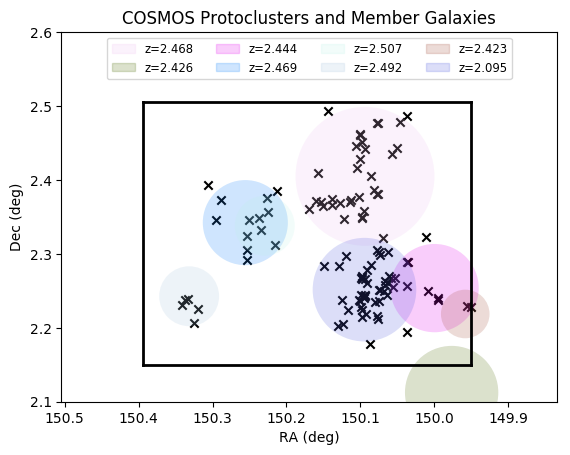

In [4]:

pclist_fil = 'titan_protoclusters.txt'
pclist = ascii.read(pclist_fil, delimiter='\s')

pclist['x'] = (np.asarray(pclist['ra'].data) - ra0)/deg_per_Mpc
pclist['y'] = (np.asarray(pclist['dec'].data) - dec0)/deg_per_Mpc
pclist['z'] = (np.asarray(pclist['redshift'].data) - zmin)*dcomdisdz
print(pclist)

# Identify galaxies near within protocluster region defined by Cucciati. For now, 
# convert the reported volume to a spherical radius. There is a fudge factor to 
# increase the radius being considered

def getGal_inVol(xlist, ylist, zlist, pos_cen, radius):
    """For input 1D of object positions, return indices for objects within a given spherical 
    volume defined by a [x,y,z] position and radius.
    
    xlist, ylist, zlist should be 1D numpy arrays while pos_cen should be a tuple with 
    [x,y,z] of the object center"""
    
    xcen, ycen, zcen = pos_cen
    
    dsq = np.sqrt((xlist-xcen)**2 + (ylist - ycen)**2 + (zlist - zcen)**2)
    inVol = np.where(dsq <= 1.3333*radius)
    return inVol

getGal = np.asarray([])
for pctmp in pclist:
    pos1 = (pctmp['x'], pctmp['y'], pctmp['z'])
    rad1 = (np.asscalar(pctmp['volume'])*3./4./np.pi)**0.3333333  

    getGal1 = getGal_inVol(galcat['x'].data, galcat['y'].data, galcat['z'].data, 
                       pos1, rad1)
    getGal = np.append(getGal, getGal1)

mask_pc = np.zeros(len(galcat), dtype=bool)

pc_ind = np.unique(getGal.astype(int))

mask_pc[pc_ind] = True
mask_nonpc = ~mask_pc

gal_pc = galcat[mask_pc]
gal_nonpc = galcat[mask_nonpc]

print('{} protocluster galaxies found'.format(len(gal_pc)))

fig, ax = plt.subplots()

ax.set_aspect('equal','datalim')
ax.set_ylabel('Dec (deg)')
ax.set_xlabel('RA (deg)')
ax.set_ylim([2.1,2.6])
ax.invert_xaxis()

ax.set_title('COSMOS Protoclusters and Member Galaxies')

# Plot protocluster galaxies
ax.scatter(gal_pc['ra'], gal_pc['dec'],marker='x', color='k')

# Plot CLAMATO boundaries
ax.plot([ra0,ra1],[dec0,dec0], color='k',linestyle='-', linewidth=2)
ax.plot([ra1,ra1],[dec0,dec1], color='k',linestyle='-', linewidth=2)
ax.plot([ra1,ra0],[dec1,dec1], color='k',linestyle='-', linewidth=2)
ax.plot([ra0,ra0],[dec1,dec0], color='k',linestyle='-', linewidth=2)

# Plot projected radii of the protoclusters. But first convert the volume to radii
# in degrees

colorvec = np.asarray(['r','g','b', 'c', 'm',
                       'y','k','w'])
ic=0
patches=[]
colorvec=[]
legend_handle=[]
for pctmp in pclist:
    rad_deg = deg_per_Mpc*(np.asscalar(pctmp['volume'])*3./4./np.pi)**0.3333333
    colortmp = np.random.random((1,3)).tolist()[0]
    circle=mpatches.Circle((np.asscalar(pctmp['ra']), np.asscalar(pctmp['dec'])), 
                       radius=rad_deg)
    patches.append(circle)
    colorvec.append(colortmp)
    legend_handle.append(mpatches.Patch(
        label='z={}'.format(np.asscalar(pctmp['redshift'])),
        color=colortmp, alpha=0.2))
    ic += 1

p = PatchCollection(patches, alpha=0.2,facecolors=colorvec)
ax.add_collection(p)

plt.legend(handles=legend_handle,loc='upper center',ncol=4,fontsize='small')
plt.show()

From the field galaxies outside of the protoclusters, we generate a control sample with the same stellar mass and surveys (so that the redshift errors are the same).

This is done by constructing a 2D histogram and ensuring that the control sample has the same relative 2D distribution. We make sure that the control sample is at least 2x as large as the protocluster sample in order to be less noisy.

It turns out that because the protocluster galaxies are relatively massive, there a small number of bins that cannot be represented in the control sample. We simple discard these to avoid biasing the comparison. 

Then plot the stellar mass distribution for the protocluster galaxies vs the control. As expected, it's the same distribution but just 2x more galaxies.

/Users/kheegan/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/kheegan/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Discarded 7 protocluster galaxies due to insufficient control galaxies


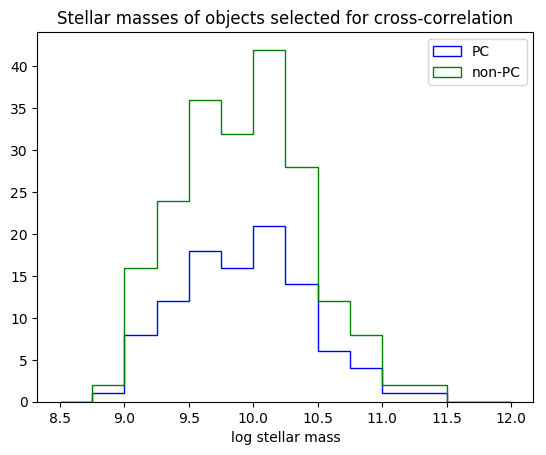

In [5]:
# generate a non-PC control sample with the same stellar mass and survey distribution

min_mstar = 8.5
max_mstar = 12.
binsize=0.25
bins_mstar = np.arange(min_mstar,max_mstar+binsize, binsize)

logmstar_pc = np.log10(gal_pc['mstar'])
logmstar_nonpc = np.log10(gal_nonpc['mstar'])

# Prepare arrays with the survey flags
survey_pc = np.zeros(np.shape(logmstar_pc), dtype=int)
survey_nonpc = np.zeros(np.shape(logmstar_nonpc), dtype=int)

survey_pc[np.where(gal_pc['source']=='CLAMATO')] = 1
survey_nonpc[np.where(gal_nonpc['source']=='CLAMATO')] = 1

survey_pc[np.where(gal_pc['source']=='MOSDEF')] = 2
survey_nonpc[np.where(gal_nonpc['source']=='MOSDEF')] = 2
survey_pc[np.where(gal_pc['source']=='ZFIRE')] = 2
survey_nonpc[np.where(gal_nonpc['source']=='ZFIRE')] = 2

survey_pc[np.where(gal_pc['source']=='VUDS')] = 3
survey_nonpc[np.where(gal_nonpc['source']=='VUDS')] = 3

survey_pc[np.where(gal_pc['source']=='zDeep')] = 4
survey_nonpc[np.where(gal_nonpc['source']=='zDeep')] = 4

# Use 2D histogram for stellar mass and survey
bins_survey = np.arange(5)+0.5

hist2d_pc = np.histogram2d(logmstar_pc, survey_pc, bins=[bins_mstar,bins_survey])
hist2d_nonpc = np.histogram2d(logmstar_nonpc, survey_nonpc, bins=[bins_mstar,bins_survey])

hist2d_pc, bins_mstar, bins_survey = hist2d_pc
hist2d_nonpc, void1, void2 = hist2d_nonpc

# This 2D histogram now tells us the number of control galaxies to select for each 
# protocluster galaxy. 
histratio = hist2d_nonpc/hist2d_pc
histratio[np.where(~np.isfinite(histratio))]=1.e9

# if there are bins where there's a less than 2x the number of control galaxies,
# downselect the number of PC galaxies
ctrl_ratio = 2.
hist2d_sel = np.copy(hist2d_pc)  # this is the modified version of the PC histogram
hist2d_sel[np.where(histratio < ctrl_ratio)] = np.floor(
    hist2d_nonpc[np.where(histratio < ctrl_ratio)]/ctrl_ratio)

hist2d_sel = hist2d_sel.astype(np.int)
hist2d_ctrl = (hist2d_sel * (np.ones(np.shape(hist2d_sel), 
                                     dtype=int)*ctrl_ratio)).astype(np.int)

print("Discarded {} protocluster galaxies due to insufficient control \
galaxies".format((np.sum(hist2d_pc)-np.sum(hist2d_sel)).astype(int)))

nbins_mstar = np.size(bins_mstar)-1
nbins_survey= np.size(bins_survey)-1

ind_pc=np.asarray([], dtype=int)
ind_nonpc = np.asarray([], dtype=int)
for imstar in np.arange(nbins_mstar):
    for isurvey in np.arange(nbins_survey):
        if hist2d_sel[imstar, isurvey] == 0 or hist2d_ctrl[imstar, isurvey] ==0 :
            continue
        getpc, = np.where(np.all(np.column_stack([(logmstar_pc >= bins_mstar[imstar]),
                                                 (logmstar_pc < bins_mstar[imstar+1]),
                                                 (survey_pc == isurvey+1)]), axis=1))
        getnonpc, = np.where(np.all(np.column_stack([(logmstar_nonpc >= bins_mstar[imstar]),
                                                 (logmstar_nonpc < bins_mstar[imstar+1]),
                                                 (survey_nonpc == isurvey+1)]), axis=1))
        #print(getpc,hist2d_sel[imstar, isurvey])
        selpc_tmp = np.random.choice(getpc, size=np.asscalar(hist2d_sel[imstar, isurvey]),
                                     replace=False)
        #print(getnonpc,hist2d_ctrl[imstar, isurvey])
        selnonpc_tmp=np.random.choice(getnonpc, size=np.asscalar(hist2d_ctrl[imstar, isurvey]), 
                                      replace=False)
        ind_pc = np.append(ind_pc, selpc_tmp)
        ind_nonpc = np.append(ind_nonpc, selnonpc_tmp)
        
fig, ax = plt.subplots()
hist_mstar_pc=ax.hist(logmstar_pc[ind_pc], bins=bins_mstar, histtype='step', 
                      fill=False, color='blue', label='PC', normed=False)
hist_mstar_nonpc=ax.hist(logmstar_nonpc[ind_nonpc], bins=bins_mstar, histtype='step', 
                         fill=False, color='green', label='non-PC', normed=False)
ax.set_xlabel('log stellar mass')
ax.set_title('Stellar masses of objects selected for cross-correlation')

plt.legend()
plt.show()


Carry out the cross-correlation



Evaluating cross-correlation for 102 galaxies and 92772 forest pixels
2D histogram evaluation took 0.032883 seconds for first galaxy
Finished evaluating cross-correlations. This took 2.306324 seconds
0 galaxies had no cross-correlations within these bins.
Evaluating cross-correlation for 204 galaxies and 92772 forest pixels
2D histogram evaluation took 0.028670 seconds for first galaxy
Finished evaluating cross-correlations. This took 4.612307 seconds
0 galaxies had no cross-correlations within these bins.


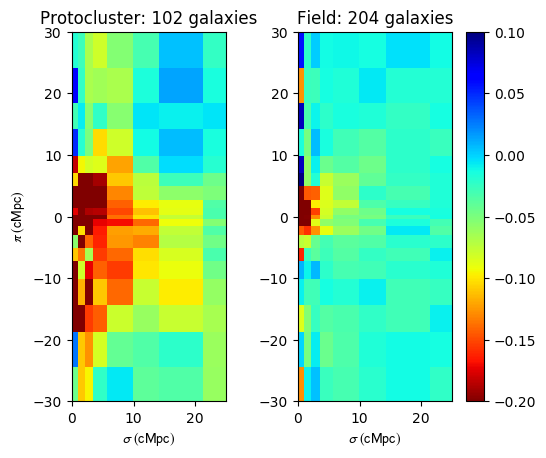

In [6]:

# These are the galaxies (both protocluster and control) which we will cross-correlate
galsel_pc = gal_pc[ind_pc]
galsel_npc = gal_nonpc[ind_nonpc]

coord_pc = SkyCoord(ra=galsel_pc['ra']*u.degree, dec=galsel_pc['dec']*u.degree, 
                   distance=cosmo.comoving_distance(galsel_pc['zspec']))
coord_npc = SkyCoord(ra=galsel_npc['ra']*u.degree, dec=galsel_npc['dec']*u.degree, 
                   distance=cosmo.comoving_distance(galsel_npc['zspec']))

XCorr_pc, NoXCorr_pc = xcorr.xcorr_gal_lya(coord_pc, lyapix, SigEdges, 
                                           PiEdges, cosmo=cosmo)

XCorr_npc, NoXCorr_npc=xcorr.xcorr_gal_lya(coord_npc, lyapix, SigEdges, 
                                           PiEdges, cosmo=cosmo)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr1 = np.rot90(XCorr_pc)
XCorrArr1 = np.flipud(XCorrArr1)

XCorrArr2 = np.rot90(XCorr_npc)
XCorrArr2 = np.flipud(XCorrArr2)


fig, (ax1,ax2) = plt.subplots(1,2)

SigMax = 25.
PiMin = -30.
PiMax = 30.

pcm=ax1.pcolormesh(X, Y, XCorrArr1,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("Protocluster: %i galaxies" % len(galsel_pc))

ax2.pcolormesh(X, Y, XCorrArr2, cmap='jet_r',vmin=-0.2,vmax=0.1)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Field: %i galaxies" % len(galsel_npc))

#fig.colorbar(pcm, ax=ax1)
fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

Plot a few of the cross-correlations along the transverse direction:

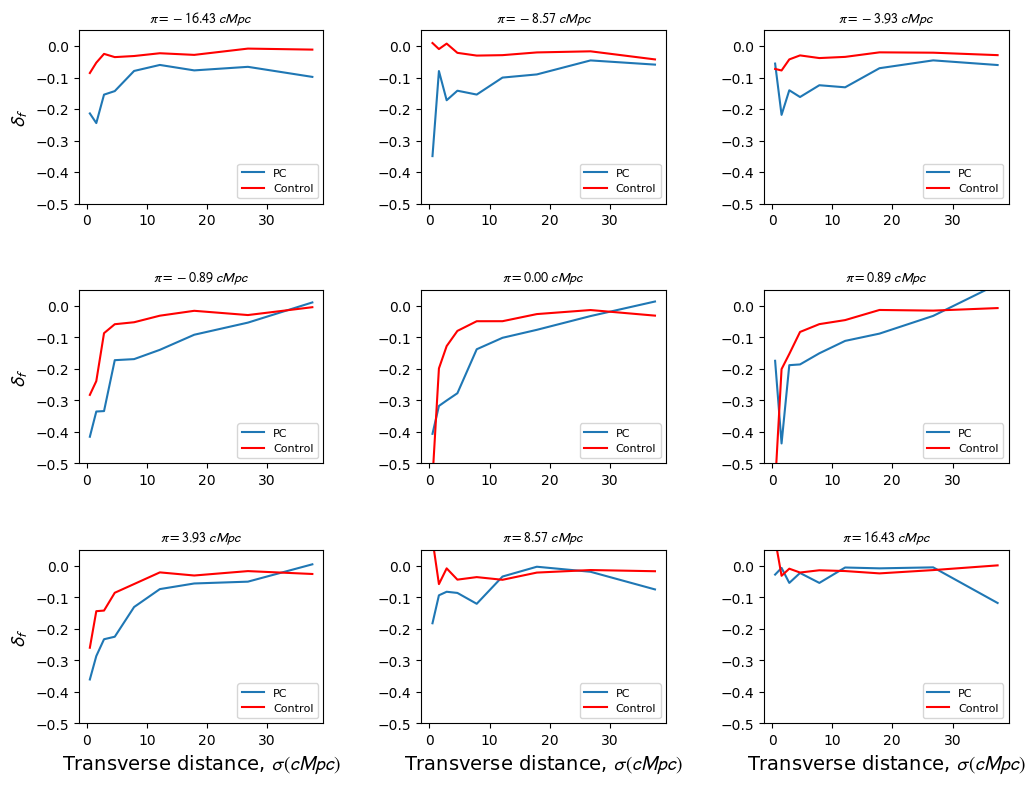

In [7]:
fig, axarr = plt.subplots(3,3,figsize=(12,9))

ind_Pi = np.asarray([5,7, 9,11,12,13,15, 17, 19])-1
PiLow = PiEdges[ind_Pi]
PiHi = PiEdges[ind_Pi+1]
PiCen = (PiEdges[ind_Pi]+PiEdges[ind_Pi+1])/2.

SigCen = np.empty(np.size(SigEdges)-1)
for i, Sig in enumerate(SigCen):
    SigCen[i] = (SigEdges[i] + SigEdges[i+1])/2.
    
for ip in np.arange(9):
    axarr[np.unravel_index(ip,np.shape(axarr))].plot(
        SigCen, XCorrArr1[ind_Pi[ip]],label='PC')
    axarr[np.unravel_index(ip,np.shape(axarr))].plot(
        SigCen, XCorrArr2[ind_Pi[ip]],color='red',label='Control')
    axarr[np.unravel_index(ip,np.shape(axarr))].set_title(
        r'$\pi={0:5.2f}\; cMpc$'.format(PiCen[ip]),fontsize=10)
    axarr[np.unravel_index(ip,np.shape(axarr))].set_ylim([-0.5,0.05])
    axarr[np.unravel_index(ip,np.shape(axarr))].legend(loc=4, fontsize=8)
    ipx, ipy =  np.unravel_index(ip,np.shape(axarr))
    if ipx == 2:
        axarr[np.unravel_index(ip,np.shape(axarr))].set_xlabel(
            r'Transverse distance, $\sigma (cMpc)$', fontsize=14)
    if ipy == 0:
        axarr[np.unravel_index(ip,np.shape(axarr))].set_ylabel(
            r'$\delta_f$',fontsize=14)

    
fig.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

Compute the ratio of protocluster vs field, and stack LOS bins closest to the center:

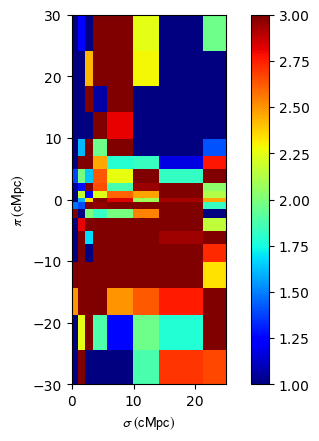

In [8]:
fig, ax1 = plt.subplots()

SigMax = 25.
PiMin = -30.
PiMax = 30.

# Compute the ratio of the protocluster cross-correlation vs field. Null out 
# the underdensities to 
XCorrArr1_tmp = np.copy(XCorrArr1)
XCorrArr1_tmp[np.where(XCorrArr1_tmp > 0.)] = 1.e-10

XCorrArr2_tmp = np.copy(XCorrArr2)
XCorrArr2_tmp[np.where(XCorrArr2_tmp > 0.)] = 1.e-10

XCorrRatio = XCorrArr1_tmp/XCorrArr2_tmp

pcm=ax1.pcolormesh(X, Y, XCorrRatio,cmap='jet',vmin=1., vmax=3. )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

fig.colorbar(pcm, ax=ax1)

plt.show()

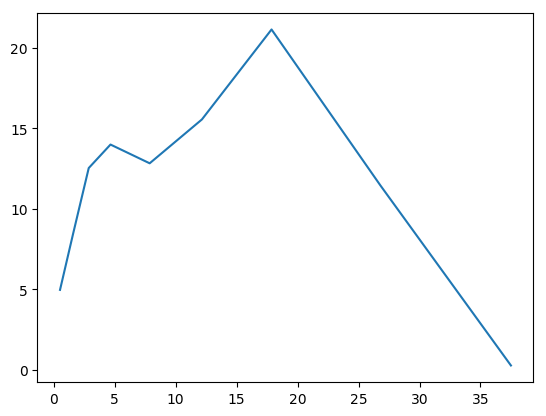

In [9]:
i_Pi_stack = np.asarray([11,12,13,14,15])-1

XCorrRatio_stack = np.sum(XCorrRatio[i_Pi_stack], axis=0)

plt.plot(SigCen, XCorrRatio_stack)